<a href="https://colab.research.google.com/github/ashwinsaba/CAI-Development/blob/master/CBD_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create student clusters on the basis of performance and writing behavior using hyerarchical clustering

---



##Introduction

The purpose of this notebook is to design the logic for the Cognitive and Behavioral Diagnostics module of C.AI. For this purpose, the high-level approach we are undertaking is nested:

***Categorize Questions --> Categorize students based on question categories***

We will discuss the approach in detail towards the end of the notebook.

## Data Prepararion

In [1]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import os
warnings.filterwarnings("ignore")
from functools import reduce
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Import the clean dataset

raw1=pd.read_csv('/content/drive/My Drive/cai_data/student_testing_clean.csv',index_col=0)
raw1['TEST_ID'] = raw1['TEST_ID'].astype(str)
raw1['QUESTION_ID'] = raw1['QUESTION_ID'].astype(str)
raw1['STUDENT_ID'] = raw1['STUDENT_ID'].astype(str)
raw1.describe()

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,TOTAL_DELAY_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,DELAY_5S,DELAY_10S,DELAY_20S,DELAY_30S,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK
count,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000
mean,0.582039,149.447006,26.369579,22.180178,123.862379,96.043366,27.137864,10.118042,7.344498,5.883819,4.911893,2.668689,1.251699,0.738107,78.803446,0.653389,1.031146,1.198605,-1.457929
std,0.493244,140.198458,31.377509,18.490791,101.118197,80.293039,20.242756,7.252593,5.254377,4.235704,3.583108,2.208786,1.352745,0.993190,65.047872,0.438426,0.787130,1.041637,2.290394
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,-32.000000
25%,0.000000,65.000000,9.000000,8.750000,53.000000,36.000000,12.000000,5.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,31.365000,0.320000,0.430000,0.400000,-2.000000
50%,1.000000,113.000000,16.000000,17.000000,94.000000,74.000000,22.000000,8.000000,6.000000,5.000000,4.000000,2.000000,1.000000,0.000000,61.010000,0.570000,0.880000,0.940000,-1.000000
75%,1.000000,192.000000,30.000000,31.000000,163.000000,134.000000,37.000000,14.000000,10.000000,8.000000,7.000000,4.000000,2.000000,1.000000,108.242500,0.890000,1.450000,1.730000,0.000000
max,1.000000,1984.000000,283.000000,111.000000,853.000000,486.000000,123.000000,45.000000,33.000000,26.000000,22.000000,13.000000,7.000000,5.000000,408.860000,2.420000,4.880000,5.950000,0.000000


In [3]:
# Subset only the tests with more than 10 questions

test_df1=raw1.groupby(['TEST_ID'])[['QUESTION_ID']].nunique().reset_index()
test_df1=test_df1.rename(columns={'QUESTION_ID':'NUM_OF_QUESTIONS'})
long_tests=test_df1['TEST_ID'][(test_df1['NUM_OF_QUESTIONS']>10)]
raw2=raw1[raw1.TEST_ID.isin(long_tests)]
raw2.describe()

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,TOTAL_DELAY_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,DELAY_5S,DELAY_10S,DELAY_20S,DELAY_30S,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK
count,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000
mean,0.640041,146.500444,26.912641,20.897680,119.982756,89.243565,25.844808,9.750602,7.069355,5.664004,4.727019,2.574109,1.218207,0.723723,74.777465,0.657630,0.987978,1.219940,-1.270445
std,0.480019,152.795400,32.391325,17.921103,98.998341,76.663032,19.584901,7.073044,5.127206,4.152978,3.518569,2.185722,1.324072,0.973201,64.097801,0.458933,0.789801,1.063639,2.141760
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,-21.000000
25%,0.000000,60.000000,9.000000,8.000000,51.000000,33.000000,11.000000,5.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,28.170000,0.300000,0.390000,0.390000,-2.000000
50%,1.000000,107.000000,16.000000,16.000000,90.000000,68.000000,21.000000,8.000000,6.000000,5.000000,4.000000,2.000000,1.000000,0.000000,56.970000,0.570000,0.820000,0.970000,0.000000
75%,1.000000,185.000000,31.000000,29.000000,158.000000,125.000000,35.000000,13.000000,10.000000,8.000000,6.000000,4.000000,2.000000,1.000000,101.230000,0.920000,1.400000,1.770000,0.000000
max,1.000000,1984.000000,283.000000,110.000000,843.000000,468.000000,123.000000,45.000000,32.000000,26.000000,22.000000,13.000000,7.000000,5.000000,408.860000,2.420000,4.880000,5.950000,0.000000


In [4]:
# Subset only the students who have answered a reasonable number of questions

studentcount_df=raw1.groupby(['STUDENT_ID'])[['QUESTION_ID']].nunique().reset_index()
studentcount_df=studentcount_df.rename(columns={'QUESTION_ID':'NUM_OF_QUESTIONS'})
long_students=studentcount_df['STUDENT_ID'][(studentcount_df['NUM_OF_QUESTIONS']>20)]
raw3=raw2[raw2.STUDENT_ID.isin(long_students)]
input_df=raw3.copy()
input_df.describe()

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,TOTAL_DELAY_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,DELAY_5S,DELAY_10S,DELAY_20S,DELAY_30S,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK
count,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000,7448.000000
mean,0.640172,141.743421,27.084989,20.614125,119.516246,87.738856,25.508996,9.644066,7.001477,5.621106,4.694817,2.560687,1.216434,0.726101,74.157489,0.654334,0.990979,1.226089,-1.235499
std,0.479982,130.557883,32.595365,17.810722,99.156744,75.762090,19.409517,7.010738,5.095265,4.130098,3.502600,2.178196,1.325961,0.973894,63.888842,0.458631,0.798458,1.067670,2.130650
min,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,-21.000000
25%,0.000000,60.000000,9.000000,8.000000,51.000000,32.000000,11.000000,4.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,27.620000,0.300000,0.380000,0.390000,-2.000000
50%,1.000000,106.000000,16.000000,16.000000,89.000000,66.000000,20.000000,8.000000,6.000000,5.000000,4.000000,2.000000,1.000000,0.000000,56.060000,0.560000,0.820000,0.980000,0.000000
75%,1.000000,183.000000,31.000000,28.000000,157.000000,123.000000,35.000000,13.000000,9.000000,8.000000,6.000000,4.000000,2.000000,1.000000,100.300000,0.910000,1.410000,1.790000,0.000000
max,1.000000,1984.000000,283.000000,110.000000,843.000000,466.000000,118.000000,45.000000,32.000000,26.000000,22.000000,13.000000,7.000000,5.000000,408.860000,2.420000,4.880000,5.950000,0.000000


## Categorizing questions

###Creating flags through Hierarchical Clustering

####**1. By mean TOTAL_TIME for correct responses**

In [0]:
# First, defining the function for Fancy Dendogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

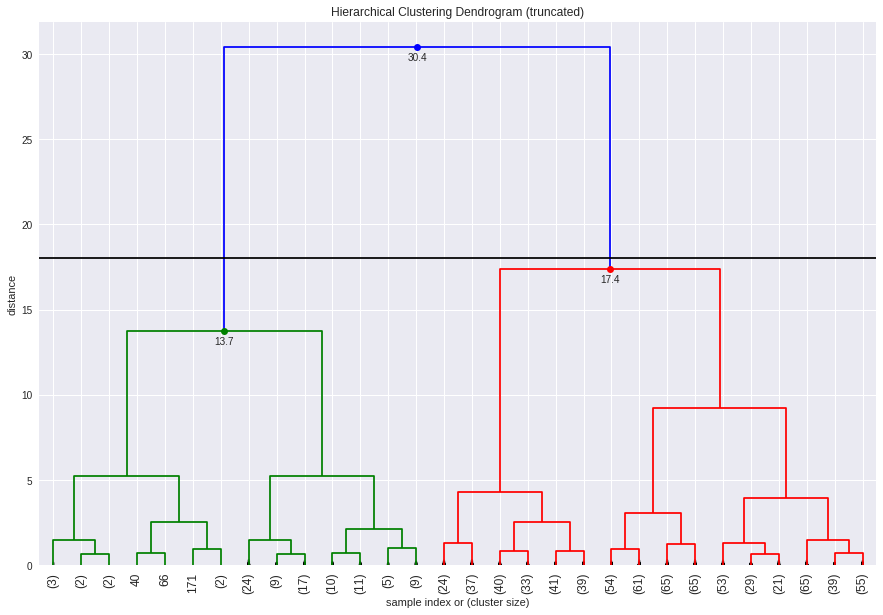

In [6]:
correct_df=input_df.loc[input_df['RESPONSE'] == 1]
question_df1=correct_df.groupby(['QUESTION_ID'])['TOTAL_TIME'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df1[['TOTAL_TIME']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=18
)

plt.show()

In [7]:
max_d = 18

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df1['CORRECT_TOTAL_TIME_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE TOTAL TIME FOR CORRECT RESPONSES: {}'.format(round(question_df1[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == i].TOTAL_TIME.mean(), 2)))

reorder rates for each cluster


label: 1
n: 97
AVERAGE TOTAL TIME FOR CORRECT RESPONSES: 332.98

label: 2
n: 721
AVERAGE TOTAL TIME FOR CORRECT RESPONSES: 117.94


In [0]:
question_df1.loc[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == 1, 'CORRECT_TOTAL_TIME_FLAG'] = 'HIGH'
question_df1.loc[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == 2, 'CORRECT_TOTAL_TIME_FLAG'] = 'LOW'

In [35]:
X = question_df1[['TOTAL_TIME']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7644995061811037

####**2. By mean TOTAL_TIME for wrong responses**

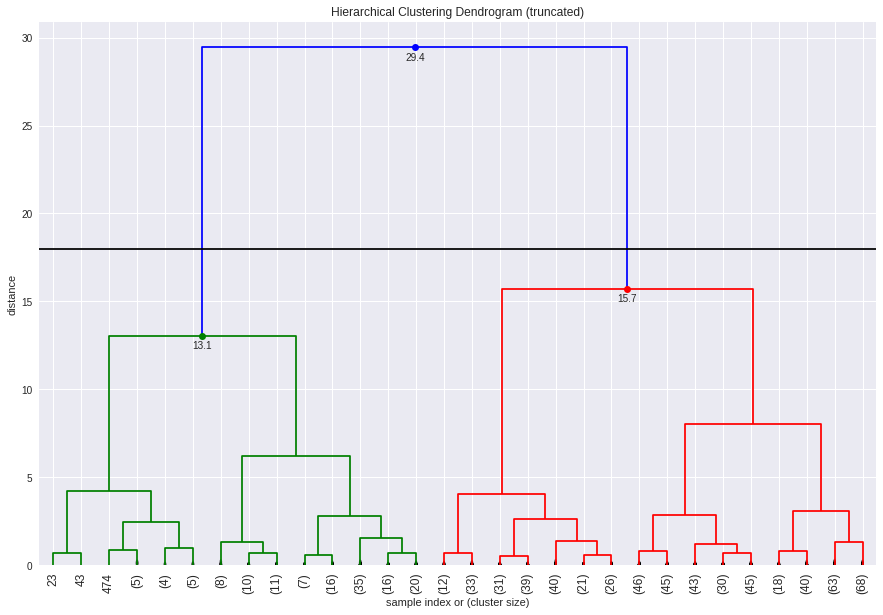

In [9]:
wrong_df=input_df.loc[input_df['RESPONSE'] == 0]
question_df2=wrong_df.groupby(['QUESTION_ID'])['TOTAL_TIME'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df2[['TOTAL_TIME']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=18
)

plt.show()

In [10]:
max_d = 18

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df2['WRONG_TOTAL_TIME_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('TOTAL TIME FOR WRONG RESPONSES: {}'.format(round(question_df2[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == i].TOTAL_TIME.mean(), 2)))

reorder rates for each cluster


label: 1
n: 140
TOTAL TIME FOR WRONG RESPONSES: 328.92

label: 2
n: 600
TOTAL TIME FOR WRONG RESPONSES: 136.68


In [0]:
question_df2.loc[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == 1, 'WRONG_TOTAL_TIME_FLAG'] = 'HIGH'
question_df2.loc[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == 2, 'WRONG_TOTAL_TIME_FLAG'] = 'LOW'

In [34]:
X = question_df2[['TOTAL_TIME']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7496513458230795

####**3. By mean success rate (to gauge difficulty level)**

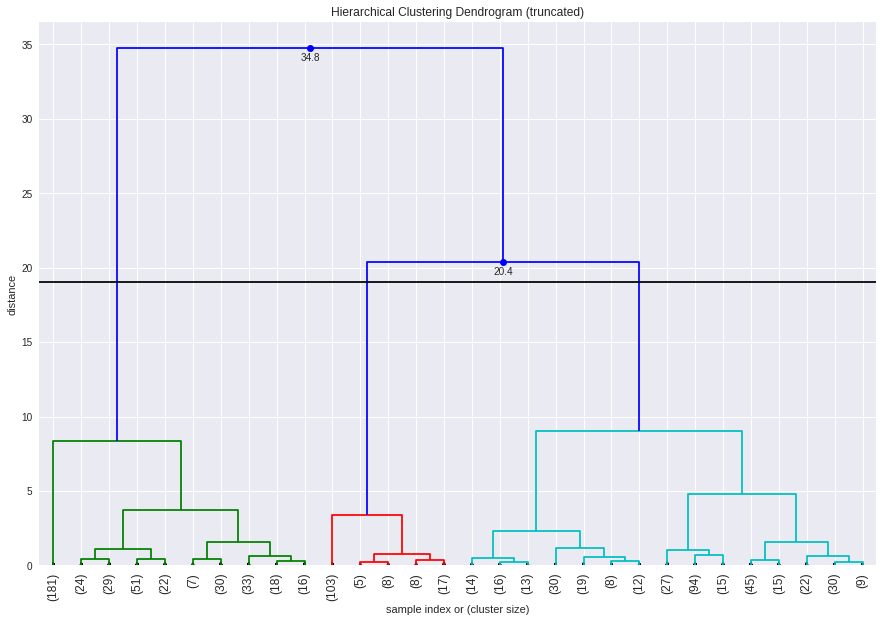

In [12]:
question_df3=input_df.groupby(['QUESTION_ID'])['RESPONSE'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df3[['RESPONSE']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=19
)

plt.show()

In [13]:
max_d = 19

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df3['CORRECT_RATE_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('CORRECT RATE: {}'.format(round(question_df3[question_df3['CORRECT_RATE_CLUSTER'] == i].RESPONSE.mean(), 2)))

reorder rates for each cluster


label: 1
n: 411
CORRECT RATE: 0.89

label: 2
n: 141
CORRECT RATE: 0.04

label: 3
n: 369
CORRECT RATE: 0.5


In [0]:
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 1, 'DIFFICULTY_FLAG'] = 'LOW'
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 2, 'DIFFICULTY_FLAG'] = 'HIGH'
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 2, 'DIFFICULTY_FLAG'] = 'MEDIUM'

In [33]:
# Validation

X = question_df3[['RESPONSE']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7118991975913315

####**4. By mean TOTAL_DELAY_1S for correct responses**

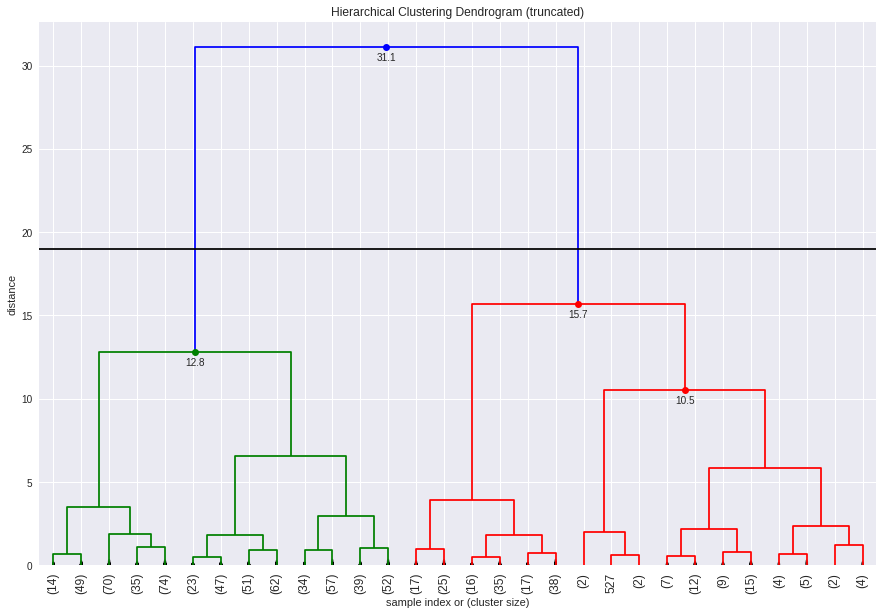

In [18]:
question_df4=correct_df.groupby(['QUESTION_ID'])['TOTAL_DELAY_1S'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df4[['TOTAL_DELAY_1S']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=19
)

plt.show()

In [19]:
max_d = 19

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df4['CORRECT_DELAY_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE DELAY COUNT FOR CORRECT RESPONSES: {}'.format(round(question_df4[question_df4['CORRECT_DELAY_CLUSTER'] == i].TOTAL_DELAY_1S.mean(), 2)))

reorder rates for each cluster


label: 1
n: 607
AVERAGE DELAY COUNT FOR CORRECT RESPONSES: 86.98

label: 2
n: 211
AVERAGE DELAY COUNT FOR CORRECT RESPONSES: 219.06


In [0]:
question_df4.loc[question_df4['CORRECT_DELAY_CLUSTER'] == 1, 'CORRECT_DELAY_FLAG'] = 'LOW'
question_df4.loc[question_df4['CORRECT_DELAY_CLUSTER'] == 2, 'CORRECT_DELAY_FLAG'] = 'HIGH'

In [32]:
# Validation

X = question_df4[['TOTAL_DELAY_1S']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7655047660093884

####**5. By mean TOTAL_DELAY_1S for wrong responses**

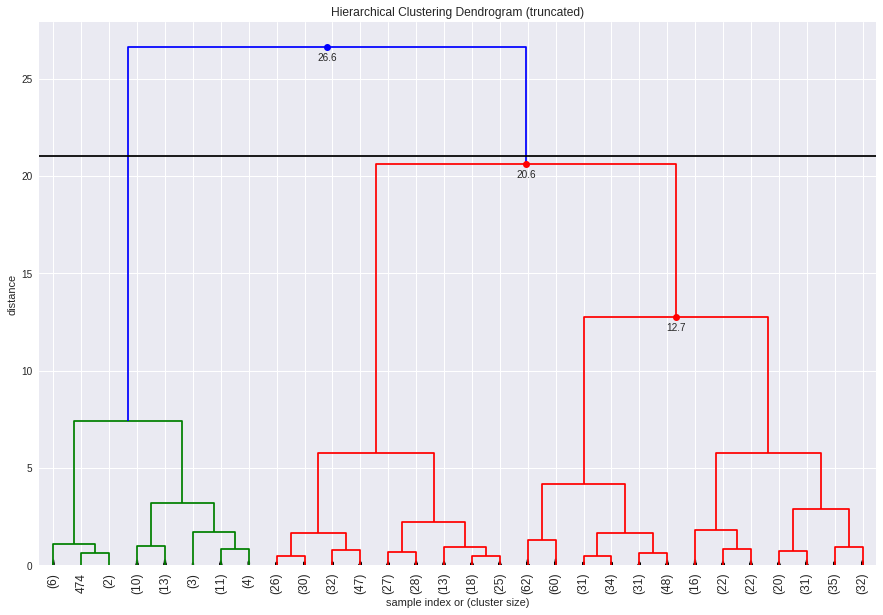

In [23]:
question_df5=wrong_df.groupby(['QUESTION_ID'])['TOTAL_DELAY_1S'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df5[['TOTAL_DELAY_1S']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=21
)

plt.show()

In [24]:
max_d = 21

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df5['WRONG_DELAY_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE DELAY COUNT FOR WRONG RESPONSES: {}'.format(round(question_df5[question_df5['WRONG_DELAY_CLUSTER'] == i].TOTAL_DELAY_1S.mean(), 2)))

reorder rates for each cluster


label: 1
n: 50
AVERAGE DELAY COUNT FOR WRONG RESPONSES: 366.63

label: 2
n: 690
AVERAGE DELAY COUNT FOR WRONG RESPONSES: 134.65


In [0]:
question_df5.loc[question_df5['WRONG_DELAY_CLUSTER'] == 1, 'WRONG_DELAY_FLAG'] = 'HIGH'
question_df5.loc[question_df5['WRONG_DELAY_CLUSTER'] == 2, 'WRONG_DELAY_FLAG'] = 'LOW'

In [31]:
# Validation

X = question_df5[['TOTAL_DELAY_1S']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7229404128821242

####**6. By mean AVERAGE_SPEED for correct responses**

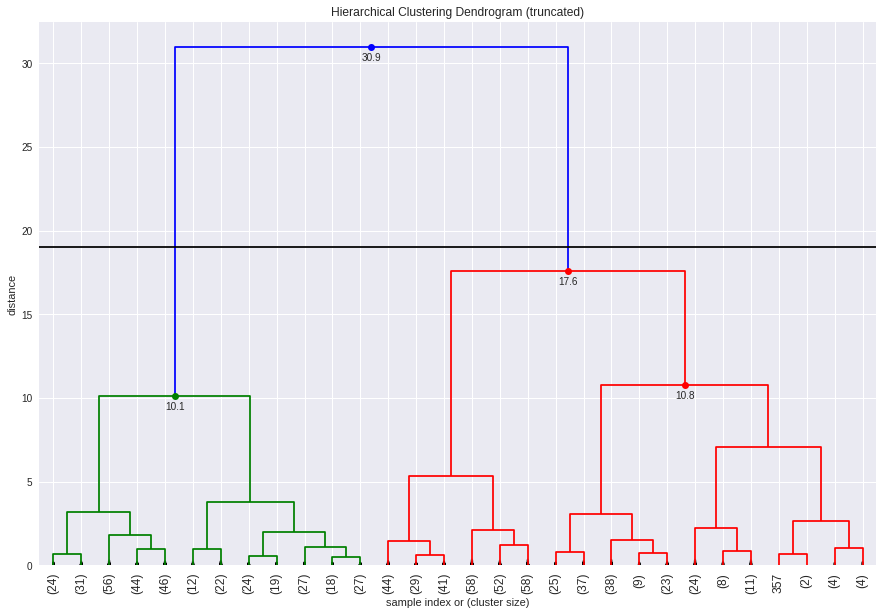

In [27]:
question_df6=correct_df.groupby(['QUESTION_ID'])['AVERAGE_SPEED'].mean().reset_index()

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df6[['AVERAGE_SPEED']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=19
)

plt.show()

In [28]:
max_d = 21

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df6['CORRECT_SPEED_CLUSTER'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE SPEED FOR CORRECT RESPONSES: {}'.format(round(question_df6[question_df6['CORRECT_SPEED_CLUSTER'] == i].AVERAGE_SPEED.mean(), 2)))

reorder rates for each cluster


label: 1
n: 350
AVERAGE SPEED FOR CORRECT RESPONSES: 0.38

label: 2
n: 468
AVERAGE SPEED FOR CORRECT RESPONSES: 0.9


In [0]:
question_df6.loc[question_df6['CORRECT_SPEED_CLUSTER'] == 1, 'CORRECT_SPEED_FLAG'] = 'LOW'
question_df6.loc[question_df6['CORRECT_SPEED_CLUSTER'] == 2, 'CORRECT_SPEED_FLAG'] = 'HIGH'

In [30]:
# Validation

X = question_df6[['AVERAGE_SPEED']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.5903479327027877

### Merging all the flags into one table

In [0]:
question_df_list = [question_df1,question_df2,question_df3,question_df4,question_df5,question_df6]
question_df_all = reduce(lambda left,right: pd.merge(left,right,on=['QUESTION_ID']), question_df_list)